In [1]:
import h5py

subject_list = [
    "sub-002", "sub-003", "sub-004", "sub-005", "sub-006", "sub-007", "sub-008",
    "sub-009", "sub-010", "sub-011", "sub-012", "sub-013", "sub-014", "sub-015",
    "sub-016", "sub-017", "sub-018", "sub-019", "sub-020", "sub-023", "sub-024",
    "sub-025", "sub-026", "sub-027", "sub-028", "sub-029", "sub-030", "sub-031",
    "sub-032", "sub-033", "sub-034", "sub-035", "sub-036", "sub-037", "sub-039",
    "sub-040", "sub-041", "sub-042", "sub-043", "sub-044", "sub-045", "sub-046",
    "sub-047", "sub-048", "sub-049", "sub-050", "sub-051", "sub-052", "sub-053",
    "sub-054", "sub-055", "sub-057", "sub-058", "sub-059", "sub-060", "sub-061",
    "sub-062", "sub-063", "sub-064", "sub-065", "sub-066", "sub-067", "sub-070",
    "sub-071", "sub-072", "sub-073", "sub-074", "sub-075", "sub-076", "sub-077",
    "sub-078", "sub-079", "sub-080", "sub-081", "sub-082"
]

# Dictionary to store timeseries data per subject
timeseries_dict = {}

# Variable to store networks once
networks = None

for subj in subject_list:
    file_path = f'shirer-components/{subj}_desc-shirercomponents.h5'
    
    print(f"\nLoading subject {subj} from: {file_path}")
    
    with h5py.File(file_path, 'r') as f:
        # Load networks only once
        if networks is None:
            networks = f['network'][:]
            print("Loaded networks:", networks)
        
        # Load timeseries and store in dictionary
        data = f['timeseries'][:]
        timeseries_dict[subj] = data
        print(f"Timeseries shape for subject {subj}:", data.shape)


Loading subject sub-002 from: shirer-components/sub-002_desc-shirercomponents.h5
Loaded networks: [b'anteriorsalience' b'auditory' b'basalganglia' b'dorsaldmn'
 b'highervisual' b'language' b'leftcontrol' b'posteriorsalience'
 b'precuneus' b'primaryvisual' b'rightcontrol' b'sensorimotor'
 b'ventraldmn' b'visuospatial']
Timeseries shape for subject sub-002: (14, 279)

Loading subject sub-003 from: shirer-components/sub-003_desc-shirercomponents.h5
Timeseries shape for subject sub-003: (14, 279)

Loading subject sub-004 from: shirer-components/sub-004_desc-shirercomponents.h5
Timeseries shape for subject sub-004: (14, 279)

Loading subject sub-005 from: shirer-components/sub-005_desc-shirercomponents.h5
Timeseries shape for subject sub-005: (14, 279)

Loading subject sub-006 from: shirer-components/sub-006_desc-shirercomponents.h5
Timeseries shape for subject sub-006: (14, 279)

Loading subject sub-007 from: shirer-components/sub-007_desc-shirercomponents.h5
Timeseries shape for subject 

In [2]:
import pandas as pd
import numpy as np

# Load pieman_segments
pieman_segments = pd.read_csv("pieman_segments.csv")

# Compute row-wise mode of LLM segment indices
segment_cols = [f"segment_idx_{i}" for i in range(6)]
pieman_segments["mode_segment"] = pieman_segments[segment_cols].apply(lambda row: row.mode().iloc[0], axis=1)

# Keep only TR and mode_segment
clean_seg = pieman_segments[["TR", "mode_segment"]].copy()

# Get one row per TR (e.g., first token in TR)
clean_seg = clean_seg.groupby("TR").agg({"mode_segment": "first"}).reset_index()

# Compute segment boundary (no boundary on the first row)
clean_seg["segment_boundary"] = (clean_seg["mode_segment"] != clean_seg["mode_segment"].shift()).astype(int)
clean_seg.loc[0, "segment_boundary"] = 0  # make sure first row is 0

# Create full TR range
full_trs = pd.DataFrame({"TR": range(1, 301)})

# Merge with existing data
clean_seg_full = pd.merge(full_trs, clean_seg, on="TR", how="left")

# Fill missing segment_boundary with 0
clean_seg_full["segment_boundary"] = clean_seg_full["segment_boundary"].fillna(0).astype(int)

# Have ready to feed into cross correlation
event_boundaries = list(clean_seg_full["segment_boundary"])

# Start with segment_boundary as a float list to allow NaNs
event_boundaries = clean_seg_full["segment_boundary"].astype(float).tolist()

event_boundaries = np.array(event_boundaries)

# Set first 13 elements to NaN
event_boundaries[:13] = np.nan

# Set from index 292 to the end to NaN
event_boundaries[292:] = np.nan

# Remove all NaN values
event_boundaries = event_boundaries[~np.isnan(event_boundaries)]

boundary_locs = [i for i, val in enumerate(event_boundaries) if val == 1]

RSA stack shape: (75, 279, 279)


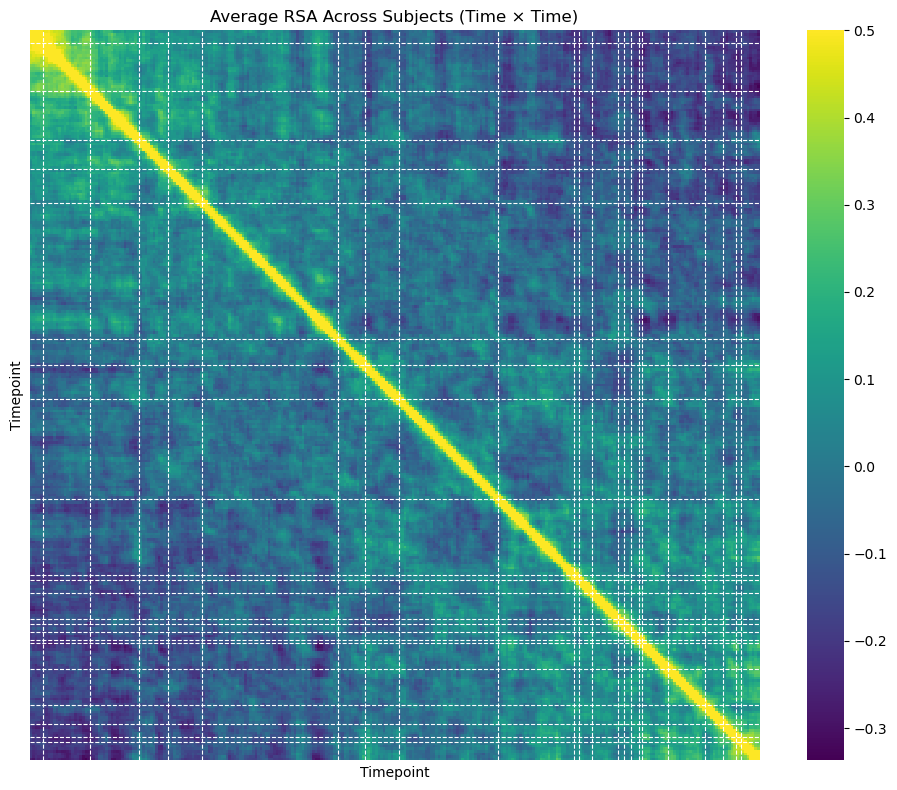

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Step 1: Compute RSA per subject
rsa_matrices = []  # list of subject-level RSA matrices

for subj in subject_list:
    data = timeseries_dict[subj]  # shape: (networks, timepoints)
    data = data.T  # shape becomes (timepoints, networks)
    
    # Optional: check and drop timepoints with NaNs
    valid_rows = ~np.isnan(data).any(axis=1)
    data = data[valid_rows, :]
    
    # Compute 1 - correlation distance (similarity)
    dissimilarity = pdist(data, metric='correlation')  # (T * (T-1) / 2,)
    rsa = 1 - squareform(dissimilarity)  # shape: (T, T)
    rsa_matrices.append(rsa)

# Step 2: Pad RSA matrices if needed (if any subjects have fewer TRs)
max_T = max(r.shape[0] for r in rsa_matrices)

rsa_matrices_padded = []
for rsa in rsa_matrices:
    T = rsa.shape[0]
    if T < max_T:
        padded = np.full((max_T, max_T), np.nan)
        padded[:T, :T] = rsa
        rsa_matrices_padded.append(padded)
    else:
        rsa_matrices_padded.append(rsa)

rsa_stack = np.stack(rsa_matrices_padded, axis=0)  # shape: (subjects, T, T)
print("RSA stack shape:", rsa_stack.shape)

# Step 3: Average across subjects
rsa_avg = np.nanmean(rsa_stack, axis=0)

# Step 4: Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(rsa_avg, cmap='viridis', square=True, xticklabels=False, yticklabels=False, vmax=0.5)
plt.title("Average RSA Across Subjects (Time × Time)")
plt.xlabel("Timepoint")
plt.ylabel("Timepoint")

# Add vertical and horizontal lines at event boundaries
for loc in boundary_locs:
    plt.axvline(x=loc, color='white', linestyle='--', linewidth=0.8)
    plt.axhline(y=loc, color='white', linestyle='--', linewidth=0.8)
    
plt.tight_layout()
plt.show()

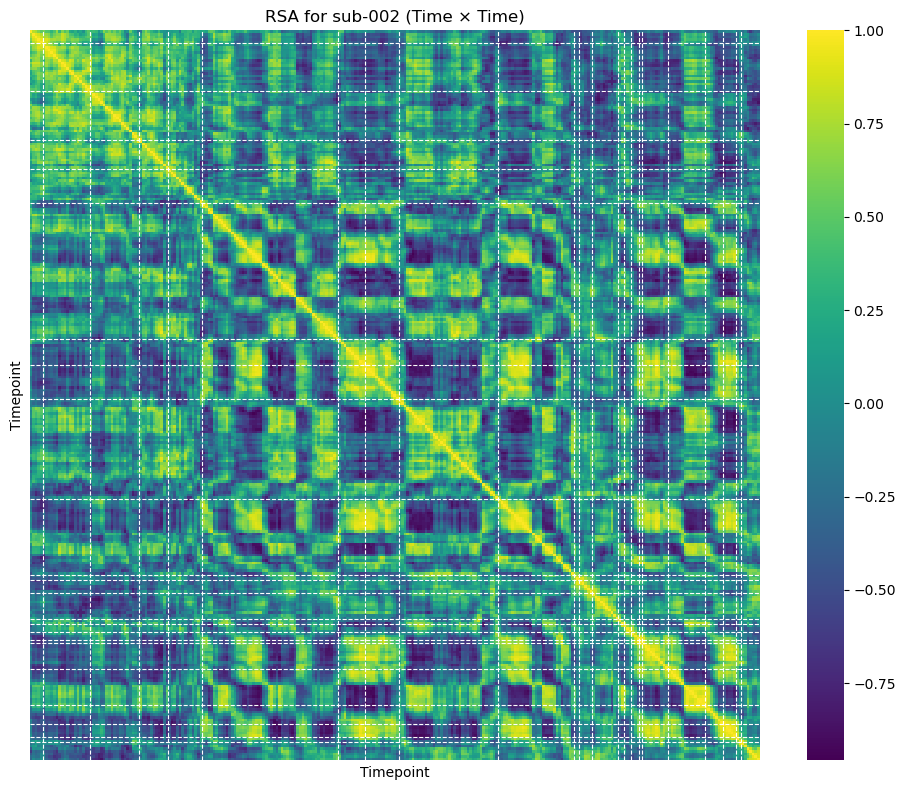

In [4]:
# Index of sub-002 in the list
subj_index = subject_list.index("sub-002")
rsa_example = rsa_matrices[subj_index]

plt.figure(figsize=(10, 8))
sns.heatmap(rsa_example, cmap='viridis', square=True, xticklabels=False, yticklabels=False)
plt.title("RSA for sub-002 (Time × Time)")
plt.xlabel("Timepoint")
plt.ylabel("Timepoint")

# Add vertical and horizontal lines at event boundaries
for loc in boundary_locs:
    plt.axvline(x=loc, color='white', linestyle='--', linewidth=0.8)
    plt.axhline(y=loc, color='white', linestyle='--', linewidth=0.8)
    
plt.tight_layout()
plt.show()

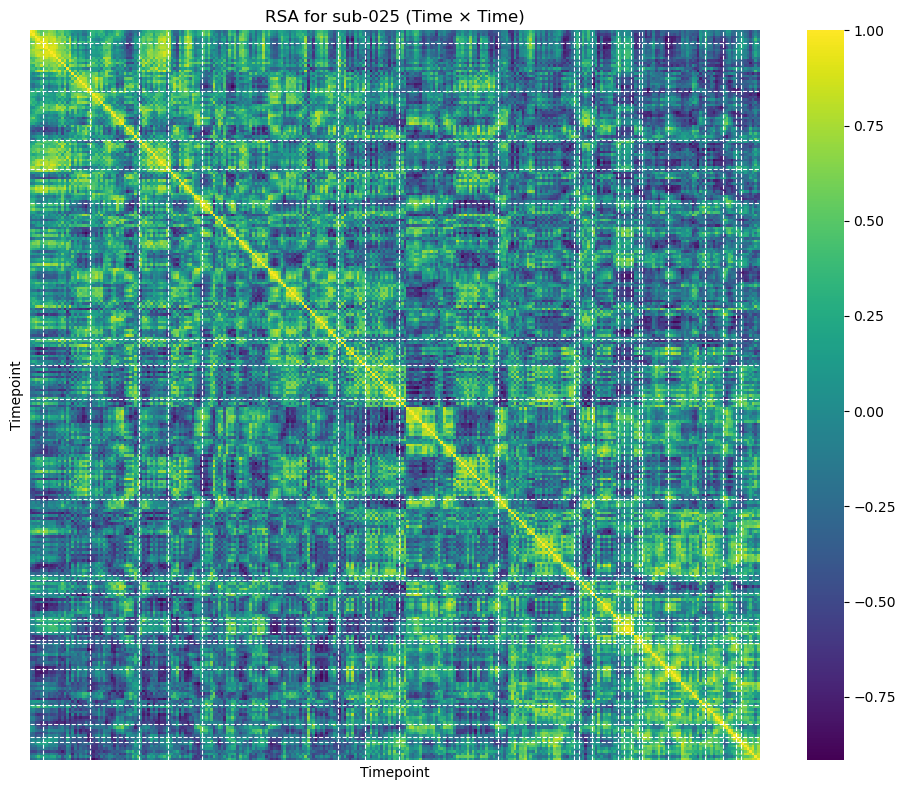

In [5]:
# Index of sub-025 in the list
subj_index = subject_list.index("sub-025")
rsa_example = rsa_matrices[subj_index]

plt.figure(figsize=(10, 8))
sns.heatmap(rsa_example, cmap='viridis', square=True, xticklabels=False, yticklabels=False)
plt.title("RSA for sub-025 (Time × Time)")
plt.xlabel("Timepoint")
plt.ylabel("Timepoint")

# Add vertical and horizontal lines at event boundaries
for loc in boundary_locs:
    plt.axvline(x=loc, color='white', linestyle='--', linewidth=0.8)
    plt.axhline(y=loc, color='white', linestyle='--', linewidth=0.8)
    
plt.tight_layout()
plt.show()

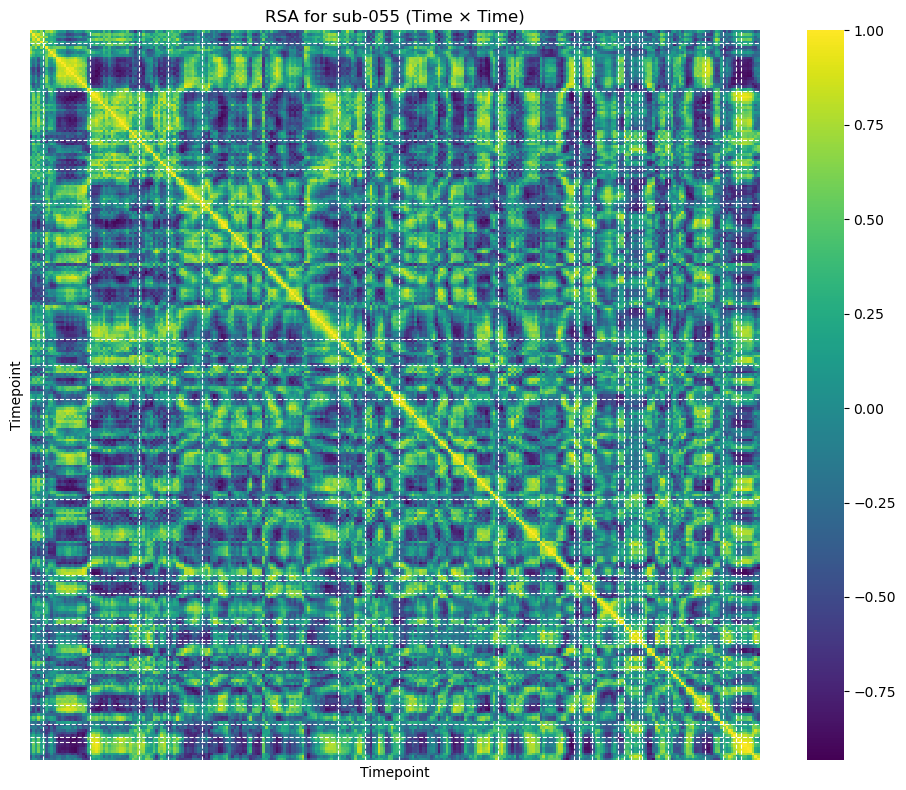

In [6]:
# Index of sub-055 in your list
subj_index = subject_list.index("sub-055")
rsa_example = rsa_matrices[subj_index]

plt.figure(figsize=(10, 8))
sns.heatmap(rsa_example, cmap='viridis', square=True, xticklabels=False, yticklabels=False)
plt.title("RSA for sub-055 (Time × Time)")
plt.xlabel("Timepoint")
plt.ylabel("Timepoint")

# Add vertical and horizontal lines at event boundaries
for loc in boundary_locs:
    plt.axvline(x=loc, color='white', linestyle='--', linewidth=0.8)
    plt.axhline(y=loc, color='white', linestyle='--', linewidth=0.8)
    
plt.tight_layout()
plt.show()

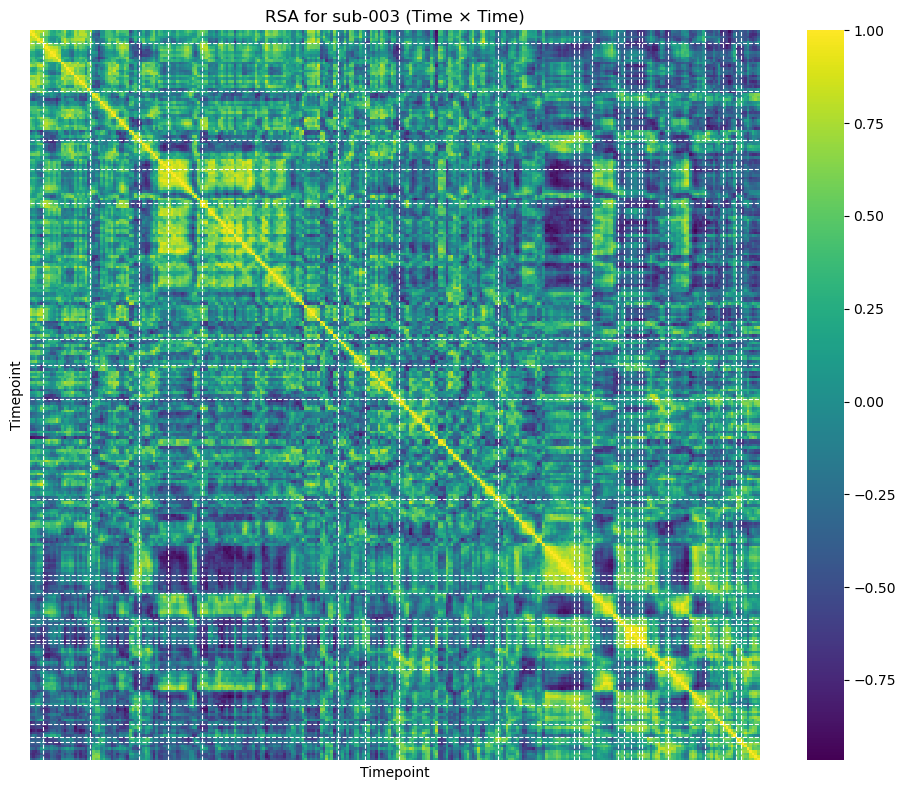

In [8]:
# Index of sub-003 in your list
subj_index = subject_list.index("sub-003")
rsa_example = rsa_matrices[subj_index]

plt.figure(figsize=(10, 8))
sns.heatmap(rsa_example, cmap='viridis', square=True, xticklabels=False, yticklabels=False)
plt.title("RSA for sub-003 (Time × Time)")
plt.xlabel("Timepoint")
plt.ylabel("Timepoint")

# Add vertical and horizontal lines at event boundaries
for loc in boundary_locs:
    plt.axvline(x=loc, color='white', linestyle='--', linewidth=0.8)
    plt.axhline(y=loc, color='white', linestyle='--', linewidth=0.8)
    
plt.tight_layout()
plt.show()